In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt

# What are SPDR Sector Funds?


SPDR Sector funds are Exchange-traded funds (ETFs) that divide the stocks that make up the S&P 500 into 11 sectors, e.g. real estate or communications. Instead of having to select and invest in individual companies from each sector to diversify their portfolio, investors can invest in these ETFs.

Naturally, using SPDR Sector Funds is just a rough measure of sector performance since it only contains a subset of stocks that are part of the S&500. A more accurate way would be to measure the returns for all publicly traded stocks belonging to an industry sector.

Here the list of SPDR Sector funds with their corresponding symbol:

- Communication Services (XLC)
- Consumer Discretionary (XLY)
- Consumer Staples (XLP)
- Energy (XLE)
- Financials (XLF)
- Health Care (XLV)
- Industrials (XLI)
- Materials (XLB)
- Real Estate (XLRE)
- Technology (XLK)
- Utilities (XLU).

In [24]:
Code2Name={
"XLC" : "Communication Services",
"XLY" : "Consumer Discretionary",
"XLP" : "Consumer Staples",
"XLE" : "Energy",
"XLF" : "Financials",
"XLV" : "Health Care",
"XLI" : "Industrials",
"XLB" : "Materials",
"XLRE" : "Real Estate",
"XLK" : "Technology",
"XLU" : "Utilities"
}

In [25]:
SPDR=yf.download(list(Code2Name.keys()))['Adj Close']

[*********************100%***********************]  11 of 11 completed


# Analysis

In [22]:
def plot(df,start=None):
    if start is None:
        start=df.index.min()
    recessions=DataReader('USREC', 'fred', start=start)['USREC']
    fig, ax = plt.subplots(figsize=(13, 9), dpi=300)
    
    if isinstance(df,pd.DataFrame):
        ylim = (df.min().min(),df.max().max())
    else:
        ylim = (df.min(),df.max())
    df.plot(ax=ax)
    ax.fill_between(recessions.index, ylim[0]-1e-2, ylim[1]+1e-2, recessions,facecolor='k', alpha=0.1)
    fig.legend
    return fig,ax

(<Figure size 3900x2700 with 1 Axes>, <Axes: xlabel='Date'>)

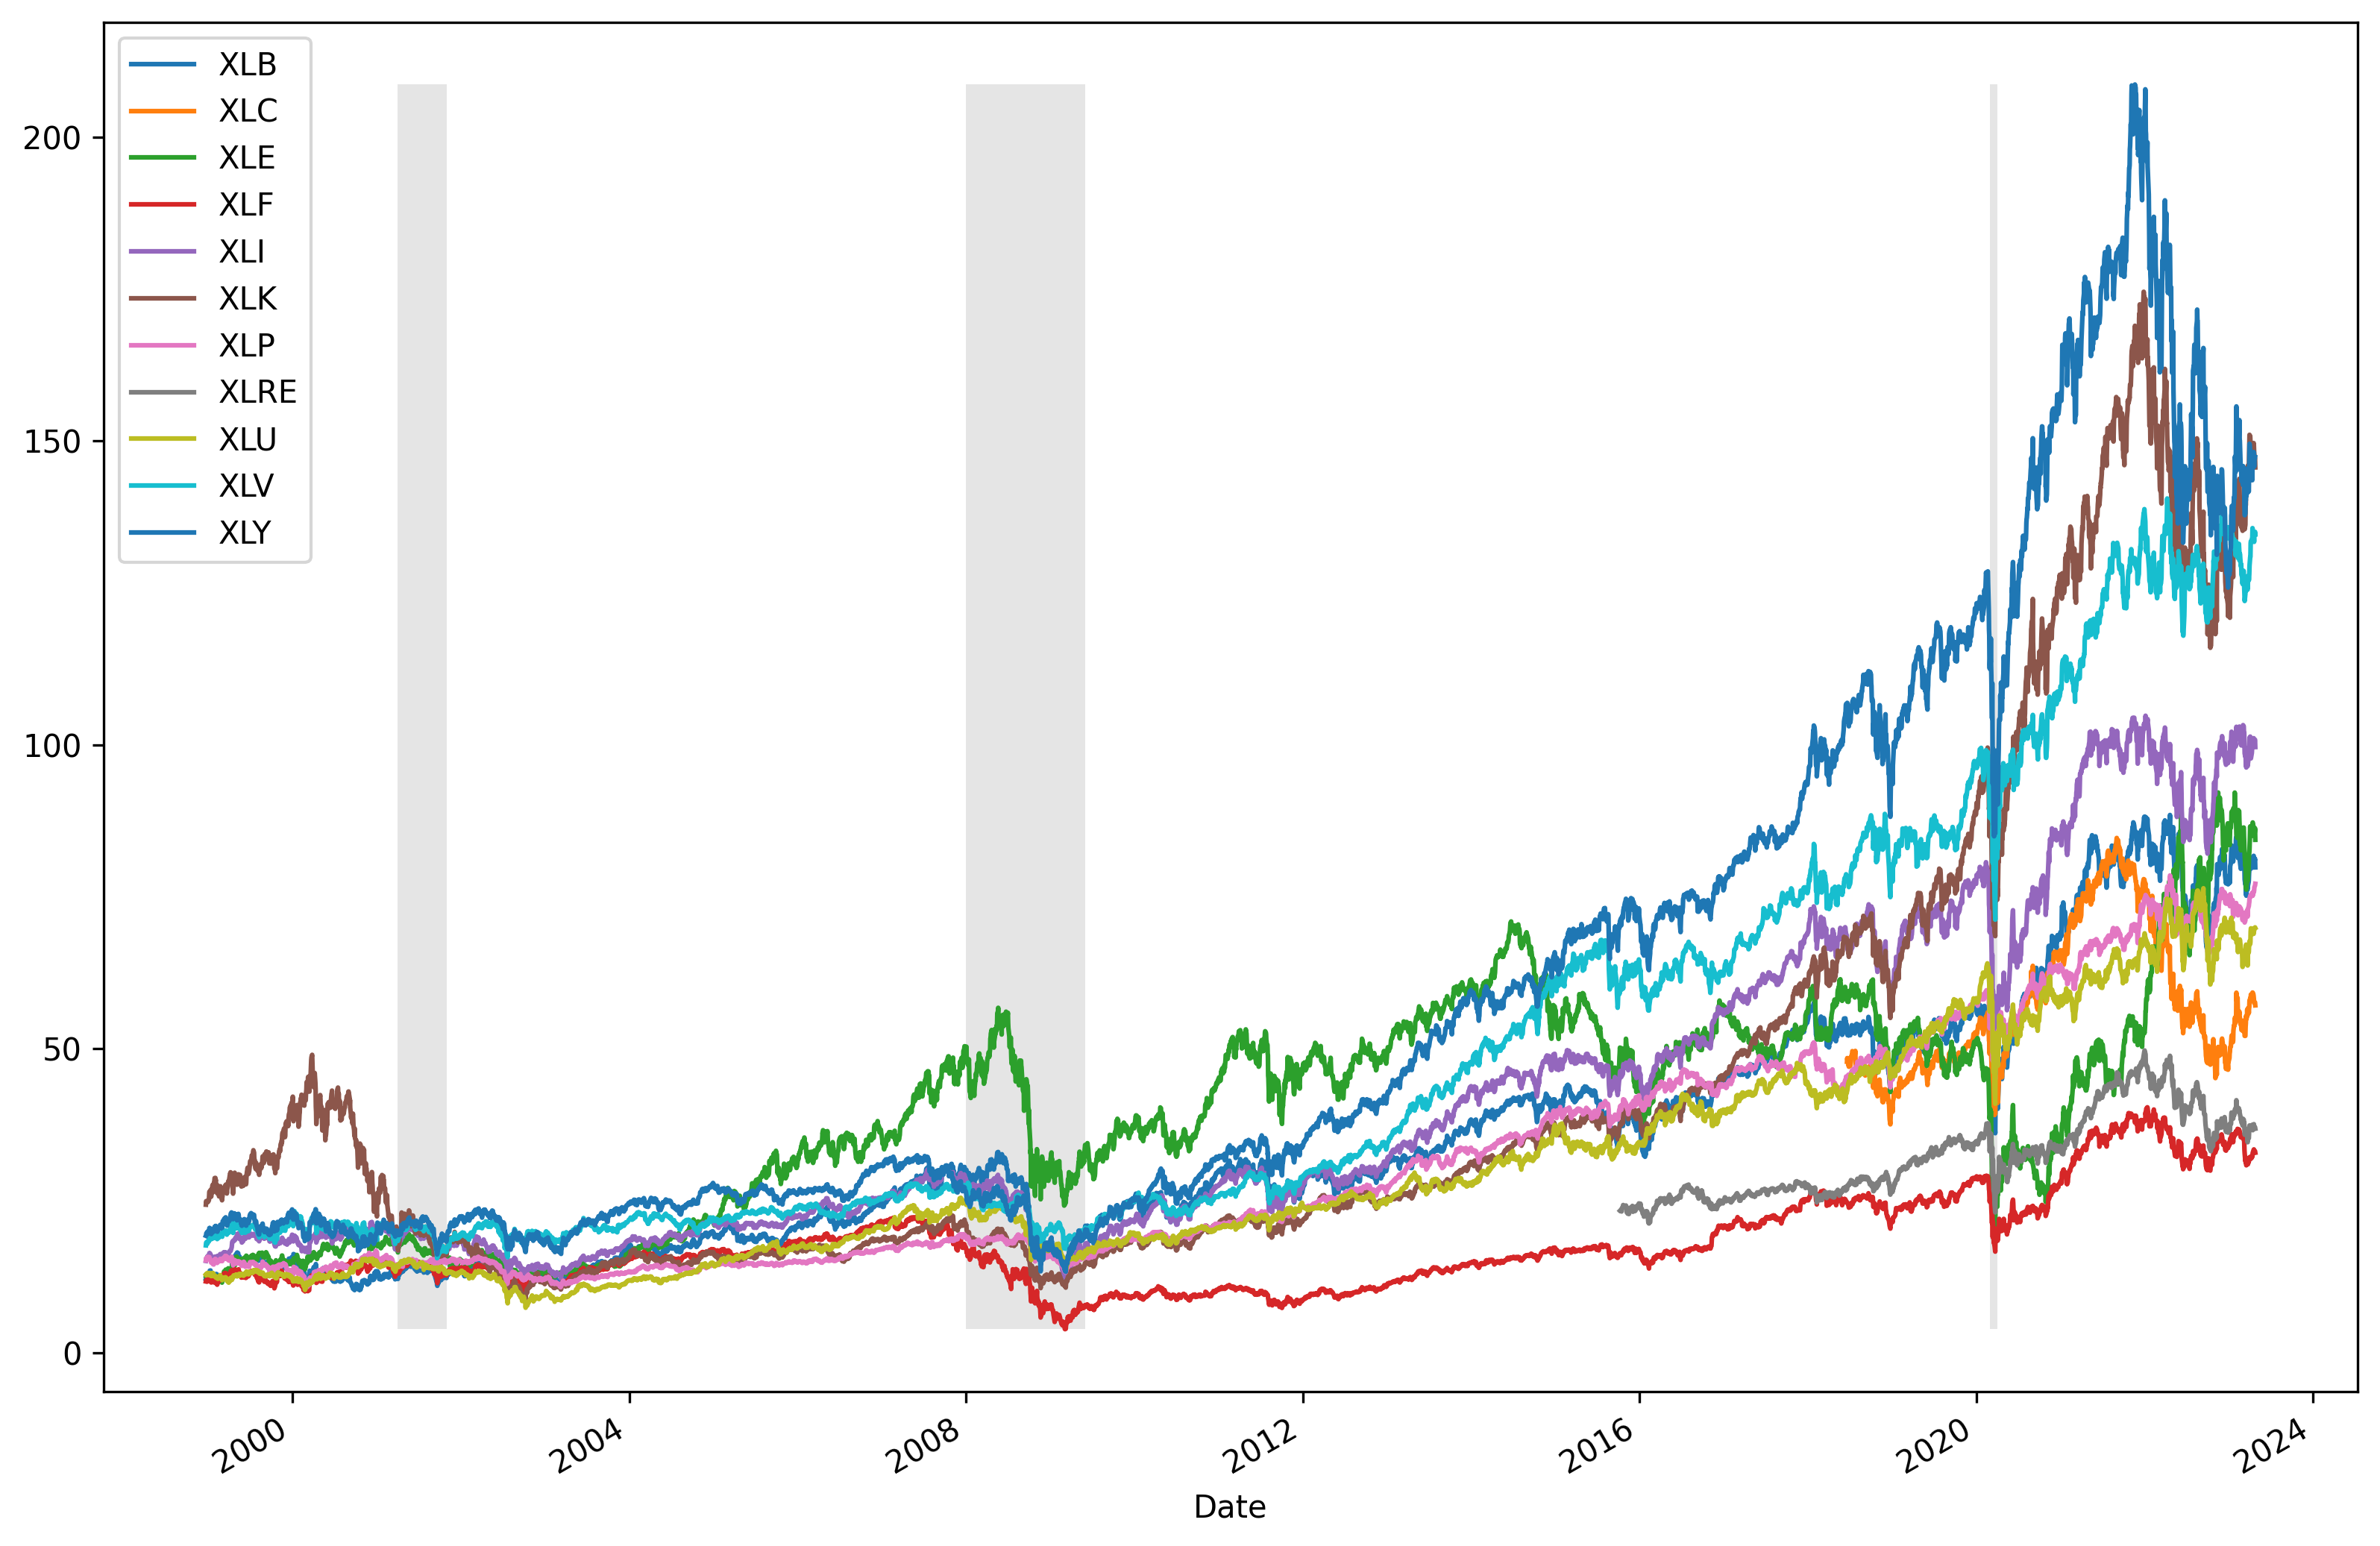

In [7]:
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
start="1999"
recessions=DataReader('USREC', 'fred', start=start)['USREC']
df=np.log1p(SPDR)
plot(SPDR)

In [8]:
recessions = DataReader('USRECQ', 'fred', start='1999').resample('QS').last()['USRECQ'].iloc[1:]
benchmark=yf.download("^GSPC")['Adj Close'] # SP500
benchmark

[*********************100%***********************]  1 of 1 completed


Date
1927-12-30      17.660000
1928-01-03      17.760000
1928-01-04      17.719999
1928-01-05      17.549999
1928-01-06      17.660000
                 ...     
2023-04-18    4154.870117
2023-04-19    4154.520020
2023-04-20    4129.790039
2023-04-21    4133.520020
2023-04-24    4137.040039
Name: Adj Close, Length: 23942, dtype: float64

In [9]:
from dateutil.relativedelta import *

my_list=recessions.to_frame()
my_list=recessions.rolling(2).mean()
my_list=my_list[my_list==0.5]
 
recessions_start_end = []

for i in range(0, len(my_list), 2):
    recessions_start_end.append((my_list.index[i], my_list.index[i+1]))


In [10]:
def PeriodPerformance(df):
    return (df.iloc[-1]  / df.iloc[0]) -1
def MonthlyPerforamnce(df):
    return df.pct_change().resample('M').apply(lambda x: (x + 1).prod() - 1).mean()

In [11]:
stock_data=df
for start,end in recessions_start_end:
    selected_data = stock_data[(stock_data.index >= start) & (stock_data.index < end)]

In [12]:
recessions_start_end

[(Timestamp('2001-04-01 00:00:00'), Timestamp('2002-01-01 00:00:00')),
 (Timestamp('2008-01-01 00:00:00'), Timestamp('2009-07-01 00:00:00')),
 (Timestamp('2020-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))]

In [13]:
df_perforamce=pd.DataFrame(index=pd.MultiIndex.from_tuples([(None,None)],name=('Year','Metrics')),columns=['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV','XLY']).dropna()

for column in list(Code2Name.keys()):
    stock_data=SPDR.loc[:,column].copy()
    for start,end in recessions_start_end:
        selected_data = stock_data[((stock_data.index) >= start) & (stock_data.index < end)]
        selected_bench = benchmark[(benchmark.index >= start) & (benchmark.index < end)]
        
        # Calculate the performance of the stock during the selected period
        performance = PeriodPerformance(selected_data)
        bench_performance = PeriodPerformance(selected_bench)
        Monthly_avg_performance = MonthlyPerforamnce(selected_data)
        Monthly_avg_benchmark = MonthlyPerforamnce(selected_bench)
        df_perforamce.loc[(str(start.year),"Period Return (%)"),column]=performance*100
        df_perforamce.loc[(str(start.year),"Period Excess Return (%)"),column]=(performance-bench_performance)*100
        df_perforamce.loc[(str(start.year),"Average Monthly Return (%)"),column]=Monthly_avg_performance*100
        df_perforamce.loc[(str(start.year),"Monthly Excess Return (%)"),column]=(Monthly_avg_performance-Monthly_avg_benchmark)*100
df_perforamce.rename(columns=Code2Name,inplace=True)
df_perforamce

Materials Communication Services     Energy  \
Year Metrics                                                                   
2001 Period Return (%)            8.464946                    NaN -10.098089   
     Period Excess Return (%)     8.272083                    NaN -10.290952   
     Average Monthly Return (%)    1.14667                    0.0  -0.943751   
     Monthly Excess Return (%)    0.982952              -0.163718  -1.107468   
2008 Period Return (%)          -35.171945                    NaN -38.083578   
     Period Excess Return (%)     1.302253                    NaN  -1.609379   
     Average Monthly Return (%)  -1.931094                    0.0  -2.164837   
     Monthly Excess Return (%)    0.312053               2.243147    0.07831   
2020 Period Return (%)           -6.032646               0.076959 -35.303416   
     Period Excess Return (%)    -1.196326               4.913279 -30.467096   
     Average Monthly Return (%)  -0.554171               0.373832  -4.962799   
     Monthly Excess Return (%)    -0.07685               0.851153  -4.485478   

                                Financials Industrials Technology  \
Year Metrics                                                        
2001 Period Return (%)           -0.113012    5.593314  -0.826454   
     Period Excess Return (%)    -0.305875    5.400451  -1.019318   
     Average Monthly Return (%)   0.073495    0.917288   0.561609   
     Monthly Excess Return (%)   -0.090222    0.753571   0.397892   
2008 Period Return (%)          -55.421088   -40.62002  -28.77353   
     Period Excess Return (%)   -18.946889   -4.145821   7.700669   
     Average Monthly Return (%)  -3.462312   -2.427138  -1.565933   
     Monthly Excess Return (%)   -1.219165   -0.183991   0.677214   
2020 Period Return (%)           -24.43668   -16.22605  12.779832   
     Period Excess Return (%)    -19.60036   -11.38973  17.616152   
     Average Monthly Return (%)  -4.038021   -2.440255   2.343395   
     Monthly Excess Return (%)     -3.5607   -1.962934   2.820716   

                                Consumer Staples Real Estate  Utilities  \
Year Metrics                                                              
2001 Period Return (%)                  5.174249         NaN  -8.670651   
     Period Excess Return (%)           4.981386         NaN  -8.863514   
     Average Monthly Return (%)         0.598093         0.0  -0.951506   
     Monthly Excess Return (%)          0.434376   -0.163718  -1.115224   
2008 Period Return (%)                 -15.84336         NaN -29.761911   
     Period Excess Return (%)          20.630839         NaN   6.712288   
     Average Monthly Return (%)        -0.834912         0.0  -1.766411   
     Monthly Excess Return (%)          1.408235    2.243147   0.476736   
2020 Period Return (%)                 -4.872906   -7.533313  -9.934503   
     Period Excess Return (%)          -0.036586   -2.696993  -5.098183   
     Average Monthly Return (%)        -0.704675   -0.979542   -1.47351   
     Monthly Excess Return (%)         -0.227354   -0.502221  -0.996189   

                                Health Care Consumer Discretionary  
Year Metrics                                                        
2001 Period Return (%)             2.000889              10.318832  
     Period Excess Return (%)      1.808026              10.125969  
     Average Monthly Return (%)    0.487626               1.375389  
     Monthly Excess Return (%)     0.323909               1.211671  
2008 Period Return (%)           -22.333942             -26.459884  
     Period Excess Return (%)     14.140257              10.014315  
     Average Monthly Return (%)   -1.228098              -1.298118  
     Monthly Excess Return (%)     1.015049               0.945029  
2020 Period Return (%)            -1.124402               1.354143  
     Period Excess Return (%)      3.711918               6.190463  
     Average Monthly Return (%)    0.005359               0.787841

<Axes: ylabel='Year-Metrics'>

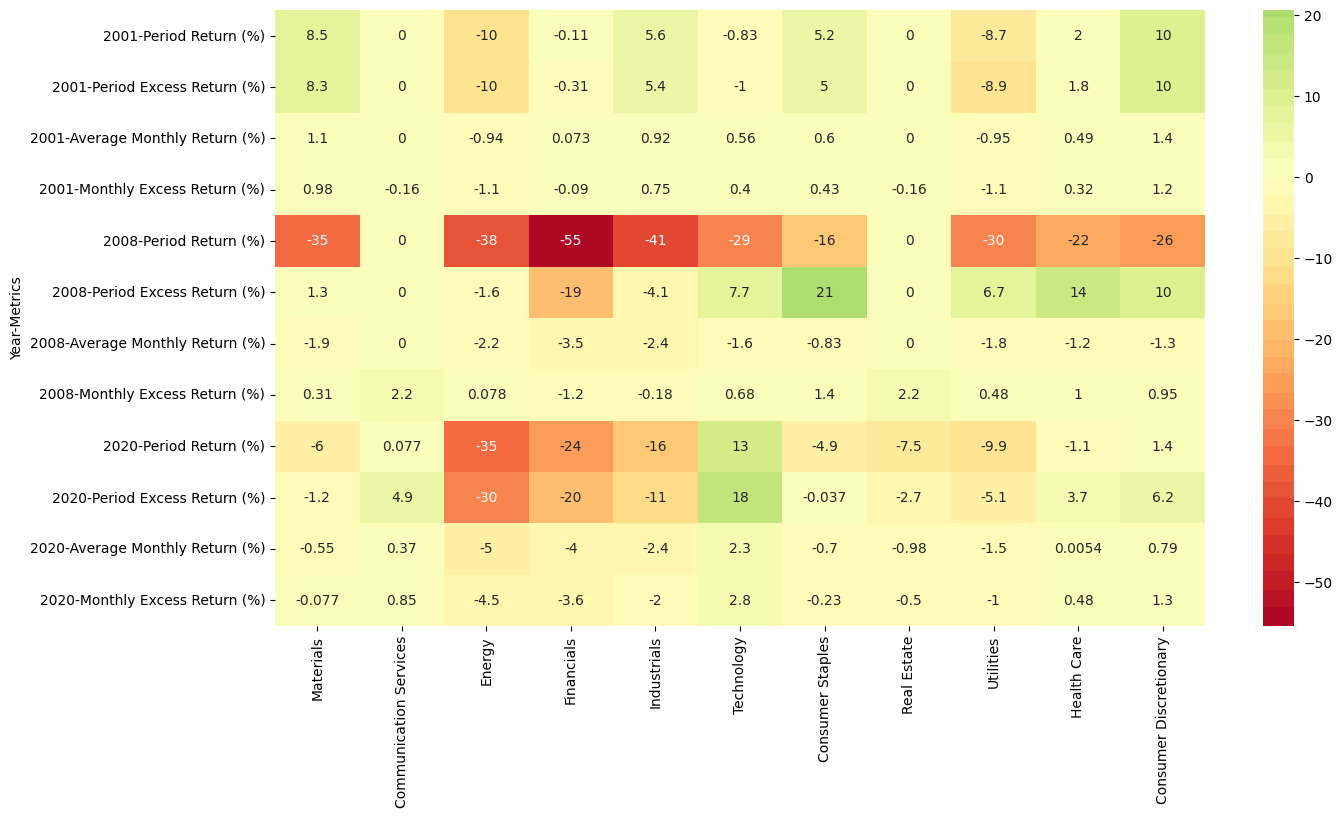

In [14]:
import seaborn as sns
palette = sns.color_palette("RdYlGn", 50)
plt.figure(figsize=(15,8))
sns.heatmap(df_perforamce.fillna(0),cmap=palette,center=0 , annot=True)

# Geting the actual data

In [15]:
import financedatabase as fd

In [16]:
equities = fd.Equities()
equities_united_states = equities.select(country="United States")


In [17]:
"TWTR" in equities_united_states.query('market=="NASDAQ Global Select"').index.to_list()

False

In [18]:
equities_united_states.head()

,name,summary,currency,sector,industry_group,industry,exchange,market,country,state,city,zipcode,website,market_cap,isin,cusip,figi,composite_figi,shareclass_figi
symbol,,,,,,,,,,,,,,,,,,,
A,"Agilent Technologies, Inc.","Agilent Technologies, Inc. provides applicatio...",USD,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,NYQ,New York Stock Exchange,United States,CA,Santa Clara,95051,http://www.agilent.com,Large Cap,US00846U1016,00846U101,BBG000C2V541,BBG000C2V3D6,BBG001SCTQY4
AA,Alcoa Corporation,"Alcoa Corporation, together with its subsidiar...",USD,Materials,Materials,Metals & Mining,NYQ,New York Stock Exchange,United States,PA,Pittsburgh,15212-5858,http://www.alcoa.com,Mid Cap,US0138721065,13872106,BBG00B3T3HK5,BBG00B3T3HD3,BBG00B3T3HF1
AABB,"Asia Broadband, Inc.","Asia Broadband Inc., through its subsidiary, A...",USD,Materials,Materials,Metals & Mining,PNK,OTC Bulletin Board,United States,NV,Las Vegas,89135,http://www.asiabroadbandinc.com,Micro Cap,NaN,NaN,NaN,NaN,NaN
AAC,Ares Acquisition Corporation,Ares Acquisition Corporation focuses on effect...,USD,Financials,Diversified Financials,Diversified Financial Services,NYQ,New York Stock Exchange,United States,NY,New York,10167,NaN,Small Cap,AU000000AAC9,NaN,NaN,NaN,NaN
AACI,Armada Acquisition Corp. I Common Stock,NaN,USD,Financials,Diversified Financials,Diversified Financial Services,NMS,NASDAQ Global Select,United States,NaN,NaN,NaN,NaN,Micro Cap,NaN,NaN,NaN,NaN,NaN


In [374]:
'TWTR' in equities_united_states

False

In [361]:
equities_united_states["market_cap"].unique()

array(['Large Cap', 'Mid Cap', 'Micro Cap', 'Small Cap', 'Nano Cap', nan,
       'Mega Cap'], dtype=object)

In [373]:
Not_Nano_MC_equities_united_states=equities_united_states.query('market_cap.isin(["Mega Cap","Large Cap","Mid Cap","Small Cap","Micro Cap"])')

In [363]:
equities_united_states.reset_index().groupby(["market_cap",]).count()[['name']].sort_values('name')

,name
market_cap,
Mega Cap,61
Large Cap,764
Mid Cap,1215
Micro Cap,2430
Small Cap,2778
Nano Cap,4828


In [20]:
equities_united_states['industry_group'].nunique()

24

In [376]:
import edgar
edgar.download()

NameError: name 'download_directory' is not defined

\begin{align}
sector\_ index_{t} =\sum _{i}\frac{{}^iMC_{t}}{\sum _{j} {}^jMC_{t}} {}^iP_{t}
\end{align}




# Lets apply this to the Utilities sector data

## Utililities

In [30]:
Util=pd.read_csv(r'Data\Scraped MarketCap\Utilities.csv',header=[0,1],index_col=0)
Utilv2=pd.read_csv(r'Data\Stockanalysis.com\Utilities sector.csv',header=[0,1],index_col=0)

In [32]:
def Append_Price(dataframe):
    df=dataframe.copy()
    df.index= pd.DatetimeIndex(df.index)

    prices=yf.download(df.columns.get_level_values(0).to_list())['Adj Close']
    prices.columns=pd.MultiIndex.from_product([['Price'], df.columns.get_level_values(0)])

    df.columns=df.columns.swaplevel(0,1)

    data_MC_P=df.join(prices,how="outer").dropna(axis=1,how='all').loc[:'2023-04-21']

    return data_MC_P


In [33]:
data_MC_P=Append_Price(Util)
data_MC_P1=Append_Price(Utilv2)

[*********************100%***********************]  90 of 90 completed
[*********************100%***********************]  92 of 92 completed


In [38]:
Utilv2.shape

(10869, 92)

In [19]:
def Make_Index(data_MC_P):
    data_MC_P_test=data_MC_P.copy()
    data_MC_P_test.fillna(0,inplace=True)
    TotalMC=data_MC_P_test['Market Cap'].sum(axis=1)
    W=data_MC_P_test['Market Cap'].apply(
                                     lambda x: np.asarray(x) * np.asarray(1/TotalMC)
                                     )
    index=(data_MC_P_test['Price']*W).sum(axis=1).to_frame('Index')
    index=index.loc[~(index==0).all(axis=1)]
    return index


In [20]:

index=Make_Index(data_MC_P)
indexv2=Make_Index(data_MC_P1).rename(columns={'Index':'IndexV2'})

C:\Users\amine\AppData\Local\Temp\ipykernel_12000\1288035864.py:6: RuntimeWarning: invalid value encountered in multiply
  lambda x: np.asarray(x) * np.asarray(1/TotalMC)
C:\Users\amine\AppData\Local\Temp\ipykernel_12000\1288035864.py:6: RuntimeWarning: invalid value encountered in multiply
  lambda x: np.asarray(x) * np.asarray(1/TotalMC)


(<Figure size 3900x2700 with 1 Axes>, <Axes: xlabel='Date'>)

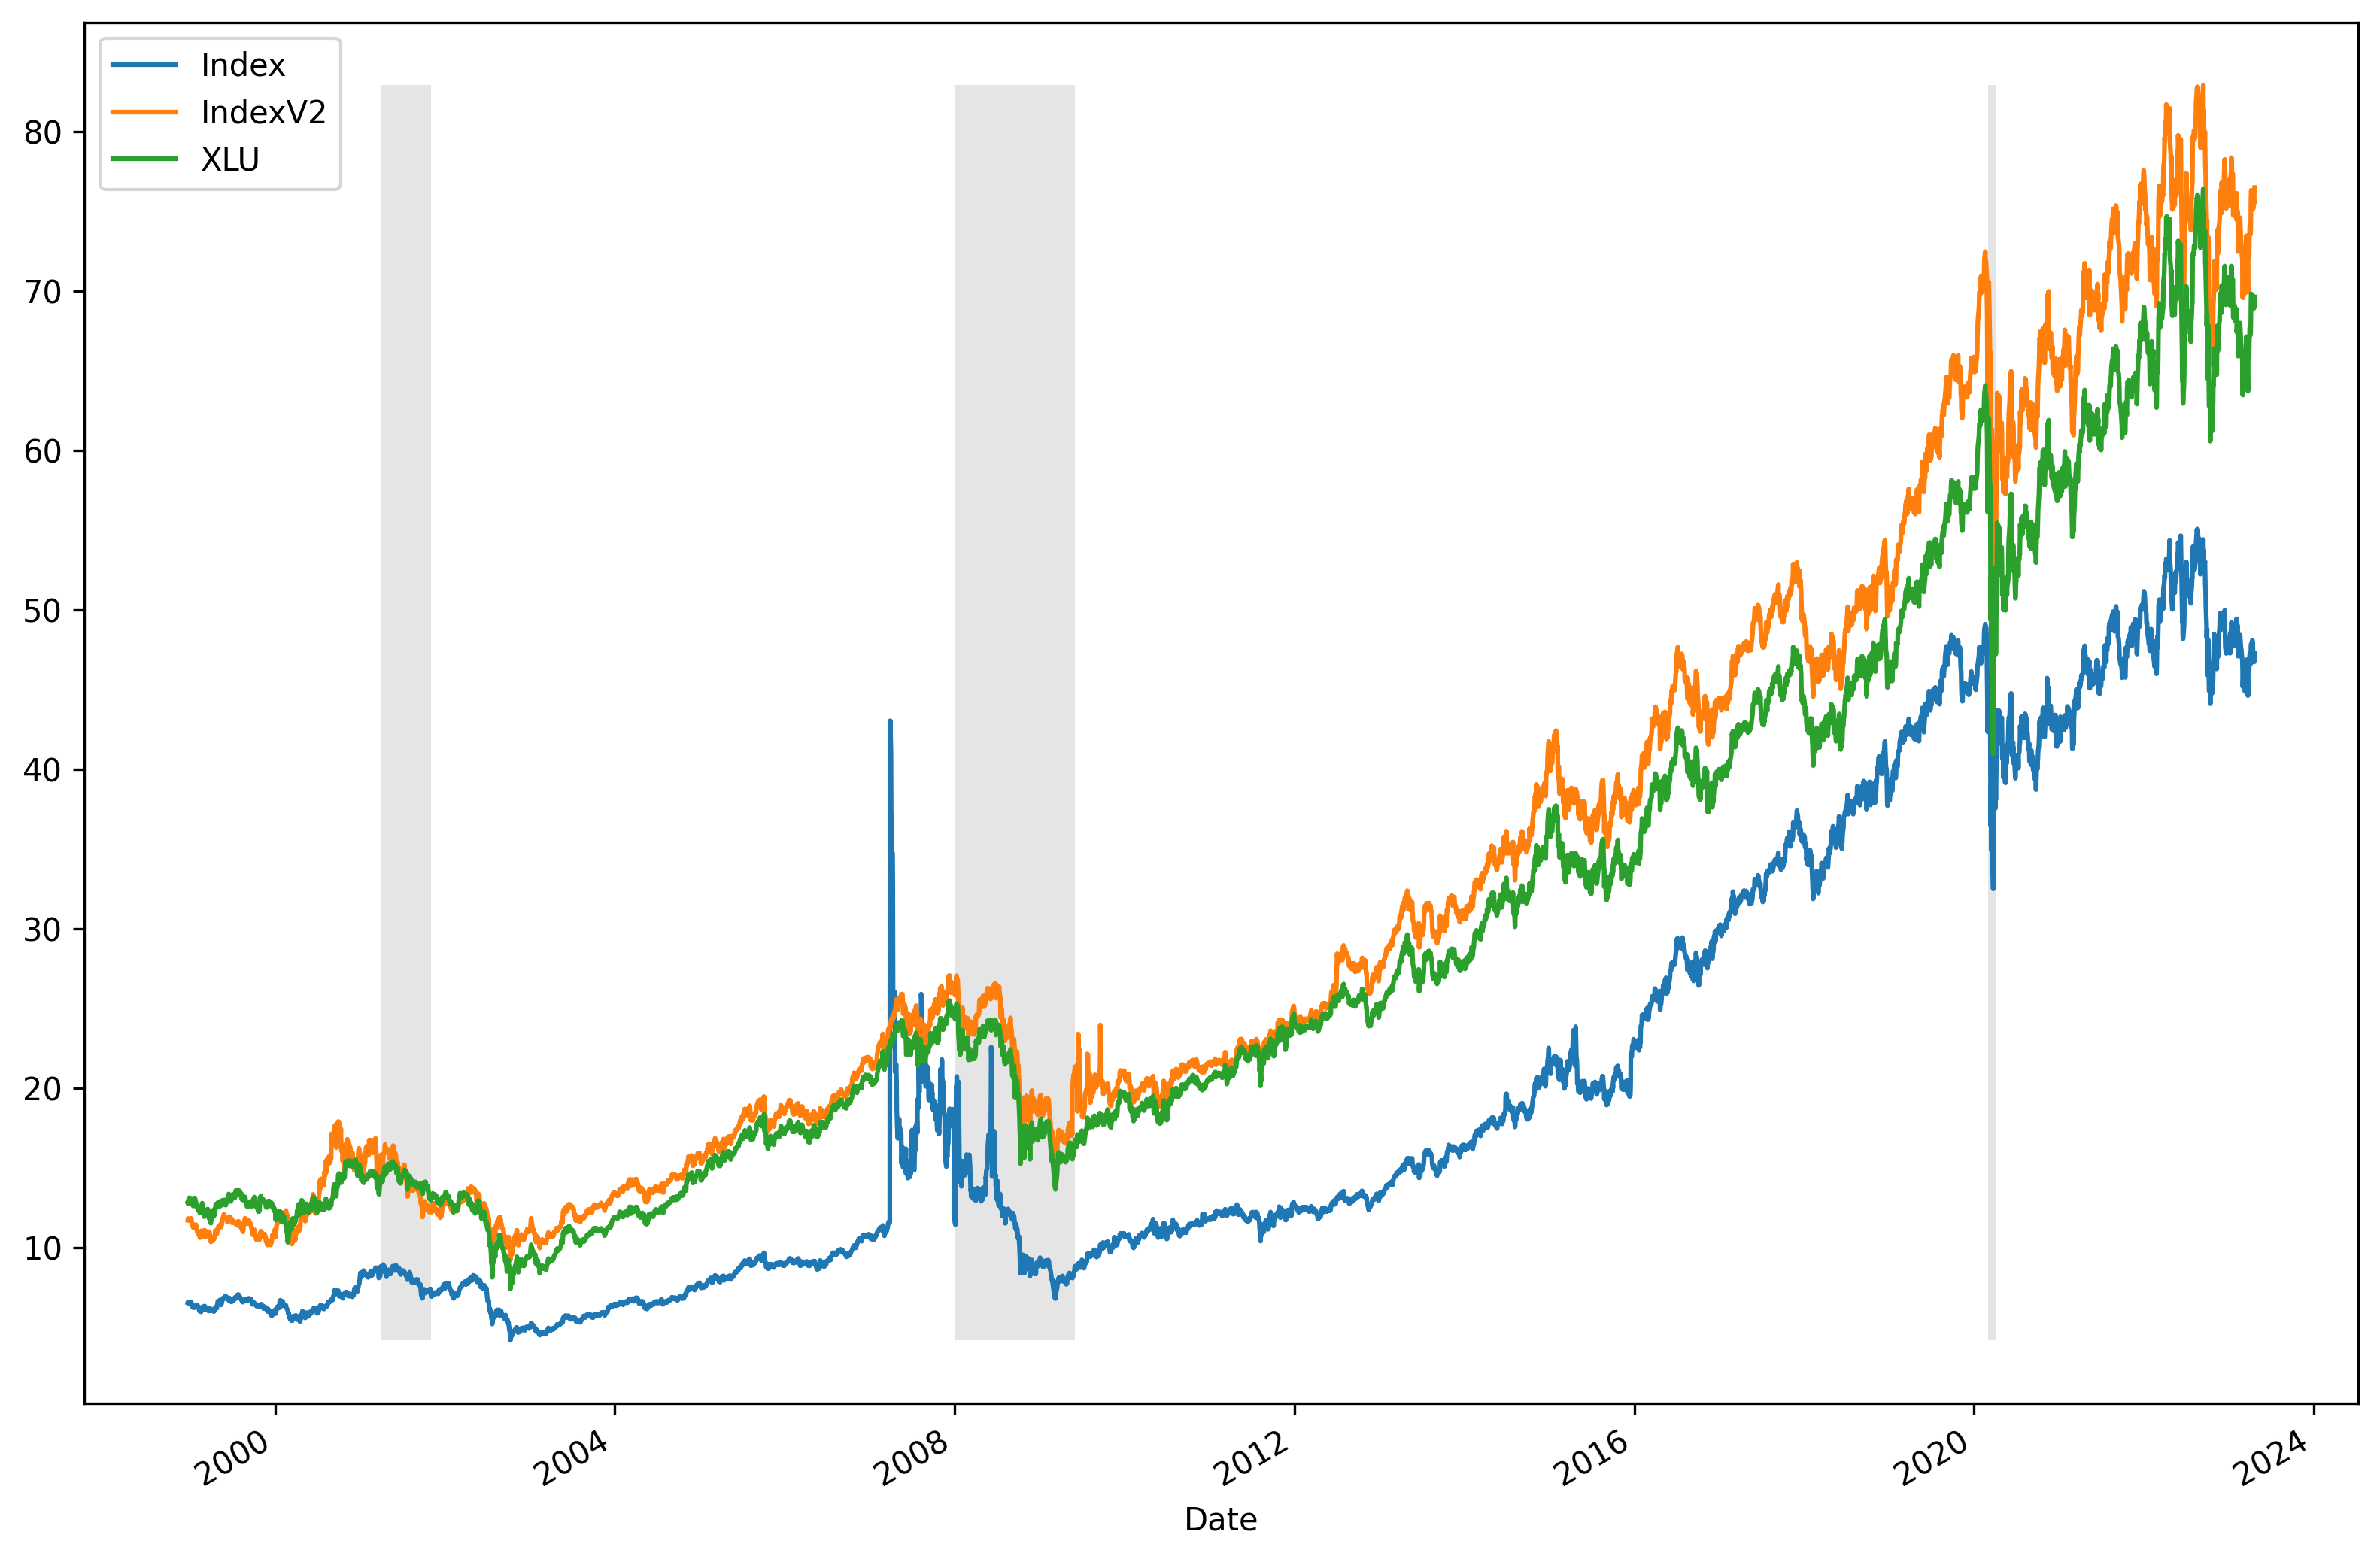

In [26]:
plot(pd.concat([index,indexv2,SPDR['XLU']],axis=1).dropna())

In [353]:
list( set( equities_united_states.query(f'sector=="Utilities"').index) - set(df.columns.get_level_values(1).to_list()))

['UEPCO',
 'OEG',
 'SJIU',
 'APRDN',
 'CNLHP',
 'PCGU',
 'CNTHO',
 'CNLTP',
 'CNLPM',
 'SRCU',
 'CNTHN',
 'PBEV',
 'SPKEP',
 'APRDM',
 'IPLDP',
 'IPWLK',
 'CNLPL',
 'UELMO',
 'CNLTN',
 'CWEN-A',
 'AILIO',
 'USWF',
 'AILLP',
 'NRTHF',
 'PPWLM',
 'VST-WTA',
 'PRHL',
 'FNRG',
 'MCPB',
 'SR-PA',
 'APRDP',
 'PVDG',
 'NI-PB',
 'SJIJ',
 'AILIH',
 'DUK-PA',
 'APRDO',
 'GRGR',
 'TRNF',
 'XGEND',
 'TORW',
 'AT',
 'NIMC',
 'CMSD',
 'AILLN',
 'DTB',
 'UEPEP',
 'NSARO',
 'UEPCN',
 'AILIN',
 'DCUE',
 'BYZN',
 'AESC',
 'AILLI',
 'UEPEM',
 'VCII',
 'NSARP',
 'DTP',
 'SRE-PB',
 'AWSL',
 'AEPPZ',
 'GNE-PA',
 'AILIM',
 'APRCP',
 'NESW',
 'UEPEO',
 'CNIGP',
 'PPWLO',
 'CLPE',
 'CNIG',
 'CNPWM',
 'NEE-PN',
 'SREA',
 'NIMMU',
 'HLXW',
 'SJI',
 'UEPEN',
 'ALPVN',
 'XGEN',
 'CMS-PB',
 'ESLP',
 'SJIV',
 'AEPPL',
 'CNTHP',
 'NEE-PO',
 'NEE-PQ',
 'AILIP',
 'CNLHN',
 'MSSEL',
 'UEPCP',
 'TPII',
 'VWTR',
 'CNP-PB',
 'CNIGO',
 'SPKE',
 'ALP-PQ',
 'CNLTL',
 'VIHD',
 'NEE-PP',
 'CNLHO']

(<Figure size 3900x2700 with 1 Axes>, <Axes: xlabel='Date'>)

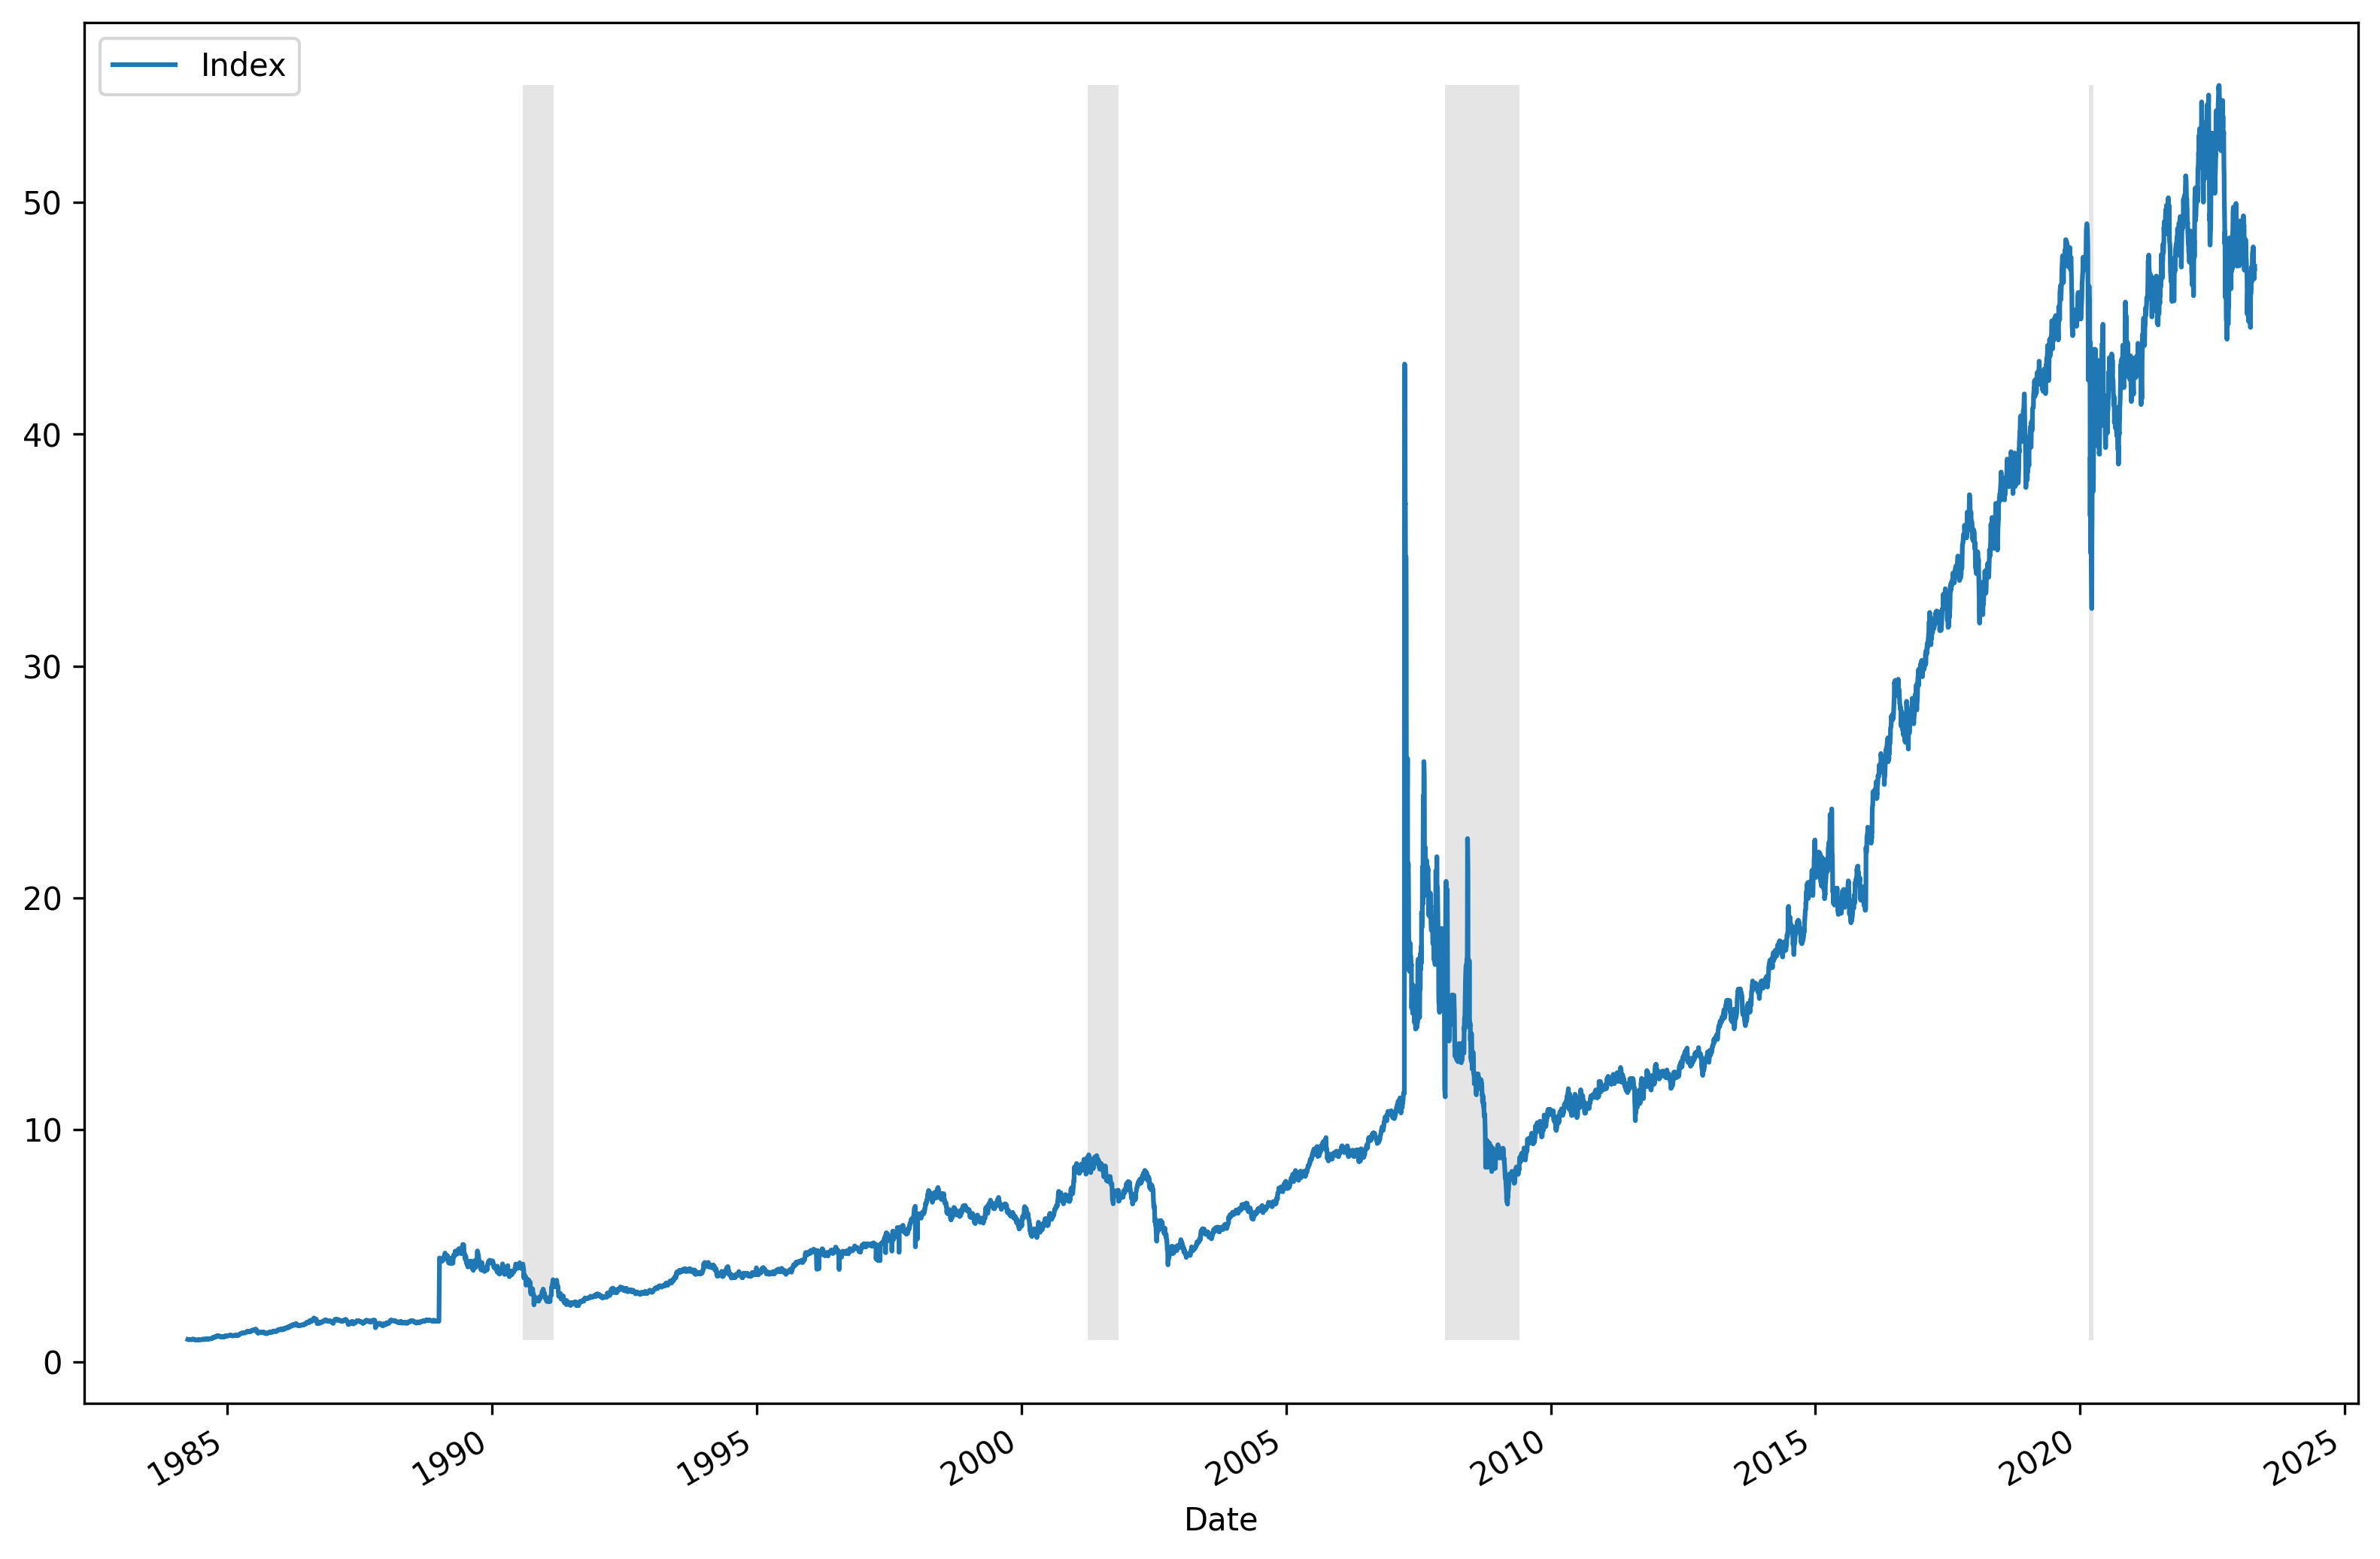

In [330]:
plot(index.dropna())

(<Figure size 3900x2700 with 1 Axes>, <Axes: xlabel='Date'>)

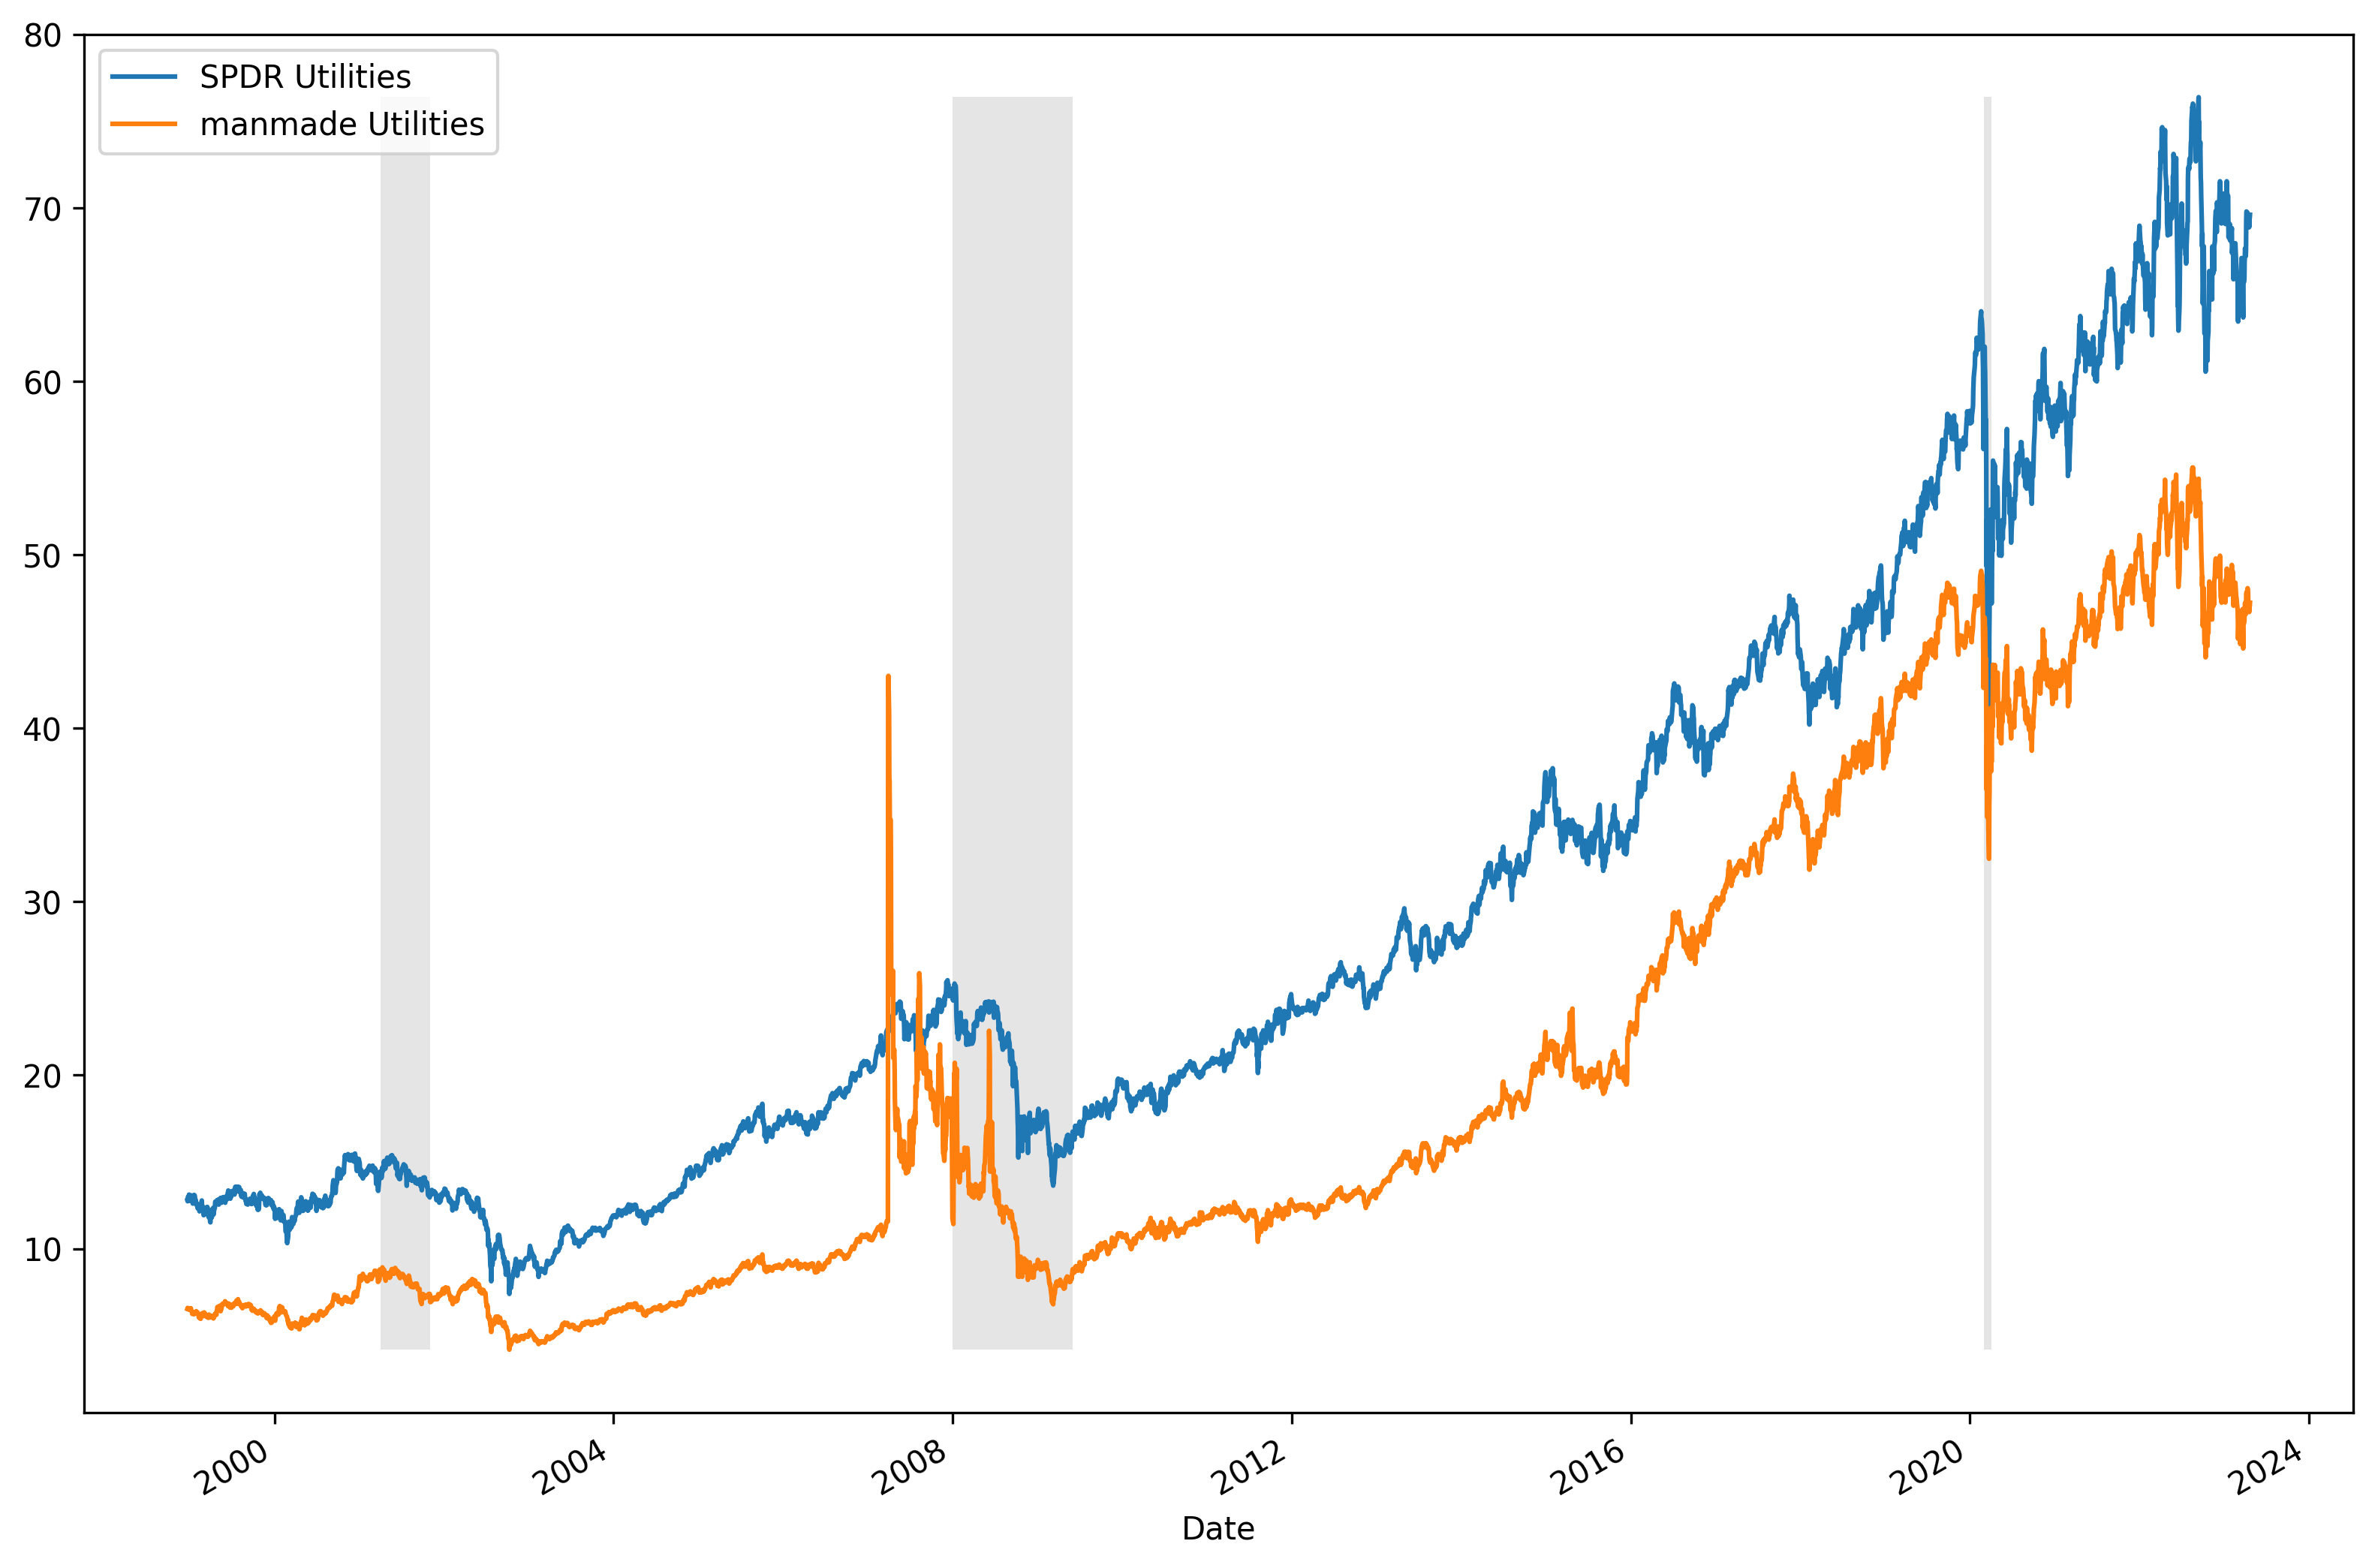

In [344]:
plot(pd.concat([SPDR['XLU'],index],axis=1).dropna().rename(columns={"XLU":'SPDR Utilities',"Index":"manmade Utilities"}))